In [129]:
import sdv
import pandas as pd
import matplotlib.pyplot as plt
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.constraints import create_custom_constraint_class
import numpy as np
import pandas as pd
from datetime import datetime as dt
import re
import time
from sdv.constraints import Inequality, create_custom_constraint_class
from copy import deepcopy
import warnings
from itertools import combinations
from sklearn.model_selection import train_test_split
from sdv.evaluation.single_table import evaluate_quality
from scipy.stats import kstest, norm, uniform, beta, expon, truncnorm
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
print(sdv.__version__)

1.2.1


In [108]:
#import data
data = pd.read_csv('American_Income.csv')
data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [109]:
data.isnull().any()

age                False
 workclass         False
 fnlwgt            False
 education         False
 education-num     False
 marital-status    False
 occupation        False
 relationship      False
 race              False
 sex               False
 capital-gain      False
 capital-loss      False
 hours-per-week    False
 native-country    False
 salary            False
dtype: bool

In [110]:
#split the dataset into feature column and target column
X = data.iloc[:,:-1]
y =data.iloc[:,-1]

In [111]:
#y_hold is being treated as the result of the perfect synthesier
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.4, random_state=42)


In [112]:
## create hold data and data for synthetic

s_data  = pd.concat([X_train,y_train], axis = 1) ##data for synthesis
data_hold = pd.concat([X_hold,y_hold], axis = 1) ##hold data for evaluation
num_of_rows = len(data_hold)
data_hold

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
14160,27,Private,160178,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,38,United-States,<=50K
27048,45,State-gov,50567,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
28868,29,Private,185908,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,55,United-States,>50K
5667,30,Private,190040,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,White,Female,0,0,40,United-States,<=50K
7827,29,Self-emp-not-inc,189346,Some-college,10,Divorced,Craft-repair,Not-in-family,White,Male,2202,0,50,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19706,22,?,255969,12th,8,Never-married,?,Not-in-family,White,Male,0,0,48,United-States,<=50K
27157,62,Self-emp-not-inc,122246,Masters,14,Divorced,Prof-specialty,Unmarried,White,Female,0,0,32,United-States,<=50K
8268,45,Self-emp-not-inc,225456,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,>50K
1836,58,Private,312131,Masters,14,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States,<=50K


## Evaluation and Comparison

### Baseline: 
Treating Holdout data as the result of the perfect sythesier, generate the quality report between hold out data and the real data

In [113]:
metadata1 = SingleTableMetadata()
metadata1.detect_from_dataframe(data = s_data)

baseline_quality_report = evaluate_quality(
    s_data,  #real data
    data_hold, #synthetic data(perfect synthesizer generated(holdout))
    metadata1
)

Creating report: 100%|██████████| 4/4 [00:00<00:00,  6.32it/s]



Overall Quality Score: 98.75%

Properties:
Column Shapes: 99.27%
Column Pair Trends: 98.22%


In [115]:
#get the score for the column shapes and column oair trends

base_line_prop_dic = baseline_quality_report.get_properties().to_dict()

base_line_prop_dic  = {base_line_prop_dic['Property'][key]: base_line_prop_dic['Score'][key] for key in base_line_prop_dic['Property']}

In [116]:
base_line_score = baseline_quality_report.get_score()

In [117]:
baseline_quality_report.get_details('Column Shapes')

,Column,Metric,Quality Score
0,age,KSComplement,0.990148
1,fnlwgt,KSComplement,0.992422
2,education-num,KSComplement,0.996398
3,capital-gain,KSComplement,0.997906
4,capital-loss,KSComplement,0.993266
5,hours-per-week,KSComplement,0.991537
6,workclass,TVComplement,0.992334
7,education,TVComplement,0.988612
8,marital-status,TVComplement,0.996049
9,occupation,TVComplement,0.983044


In [118]:
baseline_df = baseline_quality_report.get_details('Column Pair Trends')

#### Correlation Similarity:

- **Pearson Correlation Calculation**: 
  - This metric calculates the Pearson correlation for each pair of columns in the dataset.
  
- **Difference Computation**: 
  - After determining the Pearson correlation, the difference between the correlations of the real and synthetic data is computed.
  
- **Score Interpretation**: 
  - The metric returns the complement to 1 of this difference. A small difference indicates that the synthetic data has a correlation structure similar to the real data. In this case, the correlation similarity score will be close to 1. A large difference will result in a score closer to 0.
  
- **Metric Goal**: 
  - The primary aim is to assess how well the synthetic data preserves the relationships (correlations) between different columns or features in the dataset.


In [119]:
baseline_df

,Column 1,Column 2,Metric,Quality Score,Real Correlation,Synthetic Correlation
0,fnlwgt,age,CorrelationSimilarity,0.997167,-0.074365,-0.080032
1,education-num,age,CorrelationSimilarity,0.996856,0.039021,0.032733
2,capital-gain,age,CorrelationSimilarity,0.997503,0.075626,0.080620
3,capital-loss,age,CorrelationSimilarity,0.997017,0.060165,0.054198
4,hours-per-week,age,CorrelationSimilarity,0.991749,0.075393,0.058891
...,...,...,...,...,...,...
100,capital-gain,salary,ContingencySimilarity,0.997909,NaN,NaN
101,capital-loss,native-country,ContingencySimilarity,0.978955,NaN,NaN
102,capital-loss,salary,ContingencySimilarity,0.991833,NaN,NaN
103,hours-per-week,native-country,ContingencySimilarity,0.972554,NaN,NaN


In [120]:
#only show the columns has the correlation
baseline_df_has_corr = baseline_df[~baseline_df['Real Correlation'].isna()]

baseline_df_has_corr

,Column 1,Column 2,Metric,Quality Score,Real Correlation,Synthetic Correlation
0,fnlwgt,age,CorrelationSimilarity,0.997167,-0.074365,-0.080032
1,education-num,age,CorrelationSimilarity,0.996856,0.039021,0.032733
2,capital-gain,age,CorrelationSimilarity,0.997503,0.075626,0.080620
3,capital-loss,age,CorrelationSimilarity,0.997017,0.060165,0.054198
4,hours-per-week,age,CorrelationSimilarity,0.991749,0.075393,0.058891
5,education-num,fnlwgt,CorrelationSimilarity,0.997484,-0.045213,-0.040180
6,capital-gain,fnlwgt,CorrelationSimilarity,0.992298,0.006989,-0.008415
7,capital-loss,fnlwgt,CorrelationSimilarity,0.999234,-0.009662,-0.011194
8,fnlwgt,hours-per-week,CorrelationSimilarity,0.999614,-0.019080,-0.018308
9,capital-gain,education-num,CorrelationSimilarity,0.996380,0.125818,0.118577


### Generate the Synthetic Data By Using SDV

#### Module1 : GaussianCopulaSynthesizer

In [121]:
metadata1 = SingleTableMetadata()

metadata1.detect_from_dataframe(data = s_data)
synthesier = GaussianCopulaSynthesizer(metadata1)
synthesier.fit(s_data)
synthetic_data = synthesier.sample(num_rows = num_of_rows)  #keep the number of rows equal to the data hold
synthetic_data 

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,40,Self-emp-not-inc,72032,Some-college,11,Widowed,Other-service,Husband,White,Male,89168,29,49,Mexico,>50K
1,20,State-gov,81239,Masters,12,Widowed,Transport-moving,Own-child,White,Male,15075,0,42,Germany,<=50K
2,28,Private,204372,HS-grad,12,Widowed,Craft-repair,Not-in-family,Asian-Pac-Islander,Female,15,0,39,Italy,<=50K
3,43,State-gov,203263,Bachelors,7,Widowed,Prof-specialty,Husband,White,Female,34607,2,42,Mexico,<=50K
4,28,Private,309585,Some-college,15,Never-married,Other-service,Other-relative,White,Female,46879,0,37,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13020,45,State-gov,194632,10th,9,Married-civ-spouse,Transport-moving,Husband,Black,Male,1277,11,49,Haiti,>50K
13021,45,Private,152626,Assoc-voc,13,Married-civ-spouse,Sales,Husband,Amer-Indian-Eskimo,Male,1388,8,60,Haiti,>50K
13022,17,Private,208789,HS-grad,8,Widowed,Prof-specialty,Husband,White,Male,95923,0,56,United-States,>50K
13023,32,Private,175264,HS-grad,16,Widowed,Exec-managerial,Not-in-family,White,Male,4523,1,27,United-States,>50K


In [122]:
GCquality_report = evaluate_quality(
    s_data,
    synthetic_data,
    metadata1
)

Creating report: 100%|██████████| 4/4 [00:00<00:00,  6.29it/s]



Overall Quality Score: 73.11%

Properties:
Column Shapes: 76.02%
Column Pair Trends: 70.21%


In [123]:
GC_score = GCquality_report.get_score()
GC_score

0.7311144839157804

In [124]:
GCquality_prop_dic = GCquality_report.get_properties().to_dict()

GCquality_prop_dic  = {GCquality_prop_dic['Property'][key]: GCquality_prop_dic['Score'][key] for key in GCquality_prop_dic['Property']}

#### In Simple Words:

- KS Complement: It’s like comparing the shapes of two mountains (representing data distributions). If the shapes are almost identical, the KS complement value is high. If they look very different, the value is low.
- TV Complement: Imagine you have two bags of colored marbles (representing data points in distributions). The TV complement tells you how similar the mix of colors in the two bags is. A high value means the mix of colors is almost the same in both bags, while a low value means they’re quite different.

In [125]:
GCquality_report.get_details('Column Shapes')

,Column,Metric,Quality Score
0,age,KSComplement,0.976235
1,fnlwgt,KSComplement,0.952228
2,education-num,KSComplement,0.863606
3,capital-gain,KSComplement,0.094875
4,capital-loss,KSComplement,0.570266
5,hours-per-week,KSComplement,0.762271
6,workclass,TVComplement,0.763725
7,education,TVComplement,0.752412
8,marital-status,TVComplement,0.732853
9,occupation,TVComplement,0.853579


In [127]:
GC_df = GCquality_report.get_details('Column Pair Trends')

GC_df

,Column 1,Column 2,Metric,Quality Score,Real Correlation,Synthetic Correlation
0,fnlwgt,age,CorrelationSimilarity,0.993069,-0.074365,-0.060503
1,education-num,age,CorrelationSimilarity,0.982391,0.039021,0.074239
2,capital-gain,age,CorrelationSimilarity,0.981495,0.075626,0.112637
3,capital-loss,age,CorrelationSimilarity,0.983679,0.060165,0.027523
4,hours-per-week,age,CorrelationSimilarity,0.971931,0.075393,0.131532
...,...,...,...,...,...,...
100,capital-gain,salary,ContingencySimilarity,0.407781,NaN,NaN
101,capital-loss,native-country,ContingencySimilarity,0.608602,NaN,NaN
102,capital-loss,salary,ContingencySimilarity,0.887336,NaN,NaN
103,hours-per-week,native-country,ContingencySimilarity,0.525543,NaN,NaN


In [128]:
#only show the columns has the correlation
GC_df_has_corr = GC_df[~GC_df['Real Correlation'].isna()]

GC_df_has_corr

,Column 1,Column 2,Metric,Quality Score,Real Correlation,Synthetic Correlation
0,fnlwgt,age,CorrelationSimilarity,0.993069,-0.074365,-0.060503
1,education-num,age,CorrelationSimilarity,0.982391,0.039021,0.074239
2,capital-gain,age,CorrelationSimilarity,0.981495,0.075626,0.112637
3,capital-loss,age,CorrelationSimilarity,0.983679,0.060165,0.027523
4,hours-per-week,age,CorrelationSimilarity,0.971931,0.075393,0.131532
5,education-num,fnlwgt,CorrelationSimilarity,0.998679,-0.045213,-0.047855
6,capital-gain,fnlwgt,CorrelationSimilarity,0.999895,0.006989,0.007200
7,capital-loss,fnlwgt,CorrelationSimilarity,0.996647,-0.009662,-0.002956
8,fnlwgt,hours-per-week,CorrelationSimilarity,0.998064,-0.019080,-0.022951
9,capital-gain,education-num,CorrelationSimilarity,0.999846,0.125818,0.126126


#### Module2 : CTGAN Synthesier

In [131]:
from sdv.single_table import CTGANSynthesizer

ct_gan_synthesizer = CTGANSynthesizer(
    metadata1, # required
    enforce_rounding=True,
    epochs=300,  #default = 300
    verbose=True
)

ct_gan_synthesizer.fit(s_data)

ct_gan_syntheric_data  =  ct_gan_synthesizer.sample(num_rows=num_of_rows)

Epoch 1, Loss G:  1.7328,Loss D: -0.4100
Epoch 2, Loss G:  1.7793,Loss D:  0.0056
Epoch 3, Loss G:  1.5654,Loss D:  0.2427
Epoch 4, Loss G:  1.1876,Loss D:  0.0604
Epoch 5, Loss G:  1.1014,Loss D: -0.0368
Epoch 6, Loss G:  0.7206,Loss D:  0.1557
Epoch 7, Loss G:  0.6631,Loss D: -0.0171
Epoch 8, Loss G:  0.3475,Loss D:  0.0833
Epoch 9, Loss G:  0.5191,Loss D: -0.1035
Epoch 10, Loss G:  0.1443,Loss D: -0.0134
Epoch 11, Loss G: -0.0039,Loss D: -0.1042
Epoch 12, Loss G: -0.2239,Loss D: -0.0953
Epoch 13, Loss G: -0.3616,Loss D: -0.1009
Epoch 14, Loss G: -0.3565,Loss D:  0.0025
Epoch 15, Loss G: -0.7603,Loss D:  0.0179
Epoch 16, Loss G: -0.7479,Loss D: -0.1226
Epoch 17, Loss G: -0.5760,Loss D:  0.0102
Epoch 18, Loss G: -1.0748,Loss D: -0.0138
Epoch 19, Loss G: -0.6294,Loss D: -0.2285
Epoch 20, Loss G: -1.2272,Loss D: -0.0568
Epoch 21, Loss G: -1.0843,Loss D:  0.0067
Epoch 22, Loss G: -1.0244,Loss D: -0.1437
Epoch 23, Loss G: -1.1374,Loss D: -0.0576
Epoch 24, Loss G: -0.8366,Loss D: -0.0296
E

In [132]:
ct_gan_syntheric_data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,30,Private,215087,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,White,Male,5,0,60,United-States,>50K
1,30,Self-emp-inc,111067,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,30,1,40,United-States,<=50K
2,30,Private,117170,7th-8th,4,Married-civ-spouse,Other-service,Husband,White,Female,3977,0,36,Ecuador,<=50K
3,34,Private,135414,Bachelors,13,Separated,Tech-support,Not-in-family,Black,Female,28,0,40,United-States,<=50K
4,32,Private,317807,Bachelors,13,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,Mexico,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13020,23,Private,100109,Bachelors,13,Never-married,Prof-specialty,Not-in-family,Black,Male,15,0,49,?,<=50K
13021,44,Federal-gov,228367,Assoc-acdm,13,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,47,United-States,<=50K
13022,17,?,57117,12th,10,Never-married,?,Own-child,White,Female,0,0,29,United-States,<=50K
13023,34,Private,143865,HS-grad,9,Divorced,Sales,Not-in-family,White,Female,0,0,10,United-States,<=50K


In [133]:
ct_gan_quality_report = evaluate_quality(
    s_data,
    ct_gan_syntheric_data,
    metadata1
)

Creating report: 100%|██████████| 4/4 [00:00<00:00,  6.17it/s]



Overall Quality Score: 87.44%

Properties:
Column Shapes: 87.37%
Column Pair Trends: 87.52%


In [134]:
ct_gan_score = ct_gan_quality_report.get_score()

In [135]:
ct_quality_prop_dic = ct_gan_quality_report.get_properties().to_dict()
ct_quality_prop_dic  = {ct_quality_prop_dic['Property'][key]: ct_quality_prop_dic['Score'][key] for key in ct_quality_prop_dic['Property']}

In [137]:
ct_gan_quality_report.get_details('Column Shapes')


,Column,Metric,Quality Score
0,age,KSComplement,0.960271
1,fnlwgt,KSComplement,0.928809
2,education-num,KSComplement,0.945986
3,capital-gain,KSComplement,0.378944
4,capital-loss,KSComplement,0.892876
5,hours-per-week,KSComplement,0.885436
6,workclass,TVComplement,0.857084
7,education,TVComplement,0.937292
8,marital-status,TVComplement,0.912123
9,occupation,TVComplement,0.851945


In [139]:
ct_gan_df = ct_gan_quality_report.get_details('Column Pair Trends')

ct_gan_df

,Column 1,Column 2,Metric,Quality Score,Real Correlation,Synthetic Correlation
0,fnlwgt,age,CorrelationSimilarity,0.987794,-0.074365,-0.049952
1,education-num,age,CorrelationSimilarity,0.992483,0.039021,0.054054
2,capital-gain,age,CorrelationSimilarity,0.997202,0.075626,0.081223
3,capital-loss,age,CorrelationSimilarity,0.984111,0.060165,0.028386
4,hours-per-week,age,CorrelationSimilarity,0.979389,0.075393,0.116616
...,...,...,...,...,...,...
100,capital-gain,salary,ContingencySimilarity,0.938536,NaN,NaN
101,capital-loss,native-country,ContingencySimilarity,0.862962,NaN,NaN
102,capital-loss,salary,ContingencySimilarity,0.923333,NaN,NaN
103,hours-per-week,native-country,ContingencySimilarity,0.820104,NaN,NaN


In [140]:
ct_gan_df_has_corr = ct_gan_df[~ct_gan_df['Real Correlation'].isna()]

ct_gan_df_has_corr

,Column 1,Column 2,Metric,Quality Score,Real Correlation,Synthetic Correlation
0,fnlwgt,age,CorrelationSimilarity,0.987794,-0.074365,-0.049952
1,education-num,age,CorrelationSimilarity,0.992483,0.039021,0.054054
2,capital-gain,age,CorrelationSimilarity,0.997202,0.075626,0.081223
3,capital-loss,age,CorrelationSimilarity,0.984111,0.060165,0.028386
4,hours-per-week,age,CorrelationSimilarity,0.979389,0.075393,0.116616
5,education-num,fnlwgt,CorrelationSimilarity,0.997502,-0.045213,-0.050209
6,capital-gain,fnlwgt,CorrelationSimilarity,0.986771,0.006989,-0.019469
7,capital-loss,fnlwgt,CorrelationSimilarity,0.993952,-0.009662,0.002433
8,fnlwgt,hours-per-week,CorrelationSimilarity,0.967336,-0.019080,0.046249
9,capital-gain,education-num,CorrelationSimilarity,0.989298,0.125818,0.104413


#### Module3 : TVAE

In [149]:
from sdv.single_table import TVAESynthesizer

TVAE_synthesizer = TVAESynthesizer(
    metadata1, # required
    enforce_min_max_values=True,
    enforce_rounding=True,
    epochs=300 #default 300
)

TVAE_synthesizer.fit(s_data)
TVAE_synthetic_data = TVAE_synthesizer.sample(num_rows= num_of_rows)

In [150]:
TVAE_synthetic_data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,35,Private,195987,Some-college,10,Divorced,Machine-op-inspct,Not-in-family,White,Male,1,0,51,United-States,<=50K
1,50,Self-emp-not-inc,142669,10th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,1,0,46,United-States,>50K
2,38,Private,126463,Some-college,10,Divorced,Other-service,Unmarried,White,Female,4,0,44,United-States,<=50K
3,52,Private,102796,10th,6,Married-civ-spouse,Craft-repair,Husband,White,Male,7779,0,45,United-States,>50K
4,60,Private,115549,Masters,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,53,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13020,40,Local-gov,100663,Bachelors,13,Married-civ-spouse,Prof-specialty,Not-in-family,White,Male,1,0,40,United-States,>50K
13021,23,Private,137804,Prof-school,6,Never-married,?,Not-in-family,White,Female,1,0,30,United-States,<=50K
13022,40,Private,69850,Some-college,10,Divorced,Exec-managerial,Not-in-family,White,Female,1,0,40,United-States,<=50K
13023,28,Private,202157,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,2,0,53,United-States,<=50K


In [151]:
TVAE_quality_report = evaluate_quality(
    s_data,
    TVAE_synthetic_data,
    metadata1
)

Creating report: 100%|██████████| 4/4 [00:00<00:00,  5.17it/s]



Overall Quality Score: 86.05%

Properties:
Column Shapes: 87.43%
Column Pair Trends: 84.67%


In [155]:
TVAE_score = TVAE_quality_report.get_score()

In [156]:
TVAE_quality_prop_dic = TVAE_quality_report.get_properties().to_dict()
TVAE_quality_prop_dic  = {TVAE_quality_prop_dic['Property'][key]: TVAE_quality_prop_dic['Score'][key] for key in TVAE_quality_prop_dic['Property']}

In [157]:
TVAE_quality_report.get_details('Column Shapes')

,Column,Metric,Quality Score
0,age,KSComplement,0.871755
1,fnlwgt,KSComplement,0.718368
2,education-num,KSComplement,0.866530
3,capital-gain,KSComplement,0.537409
4,capital-loss,KSComplement,0.976024
5,hours-per-week,KSComplement,0.830676
6,workclass,TVComplement,0.899900
7,education,TVComplement,0.777445
8,marital-status,TVComplement,0.957665
9,occupation,TVComplement,0.862762


In [158]:
TVAE_df = TVAE_quality_report.get_details('Column Pair Trends')

TVAE_df

,Column 1,Column 2,Metric,Quality Score,Real Correlation,Synthetic Correlation
0,fnlwgt,age,CorrelationSimilarity,0.903366,-0.074365,-0.267633
1,education-num,age,CorrelationSimilarity,0.974036,0.039021,-0.012907
2,capital-gain,age,CorrelationSimilarity,0.979287,0.075626,0.117052
3,capital-loss,age,CorrelationSimilarity,0.969993,0.060165,0.120178
4,hours-per-week,age,CorrelationSimilarity,0.968147,0.075393,0.139099
...,...,...,...,...,...,...
100,capital-gain,salary,ContingencySimilarity,0.978367,NaN,NaN
101,capital-loss,native-country,ContingencySimilarity,0.898903,NaN,NaN
102,capital-loss,salary,ContingencySimilarity,0.979571,NaN,NaN
103,hours-per-week,native-country,ContingencySimilarity,0.735530,NaN,NaN


In [159]:
TVAE_df_has_corr = TVAE_df[~TVAE_df['Real Correlation'].isna()]

TVAE_df_has_corr

,Column 1,Column 2,Metric,Quality Score,Real Correlation,Synthetic Correlation
0,fnlwgt,age,CorrelationSimilarity,0.903366,-0.074365,-0.267633
1,education-num,age,CorrelationSimilarity,0.974036,0.039021,-0.012907
2,capital-gain,age,CorrelationSimilarity,0.979287,0.075626,0.117052
3,capital-loss,age,CorrelationSimilarity,0.969993,0.060165,0.120178
4,hours-per-week,age,CorrelationSimilarity,0.968147,0.075393,0.139099
5,education-num,fnlwgt,CorrelationSimilarity,0.973774,-0.045213,-0.097664
6,capital-gain,fnlwgt,CorrelationSimilarity,0.977156,0.006989,-0.038699
7,capital-loss,fnlwgt,CorrelationSimilarity,0.992157,-0.009662,0.006024
8,fnlwgt,hours-per-week,CorrelationSimilarity,0.992830,-0.019080,-0.004741
9,capital-gain,education-num,CorrelationSimilarity,0.987920,0.125818,0.101658


## Organize The Result Summary

In [160]:
result_restructured = {
    "Method": ["Baseline Score", "Gaussian Copula Score", "CT-Gan Score", "TVAE Score"],
    "Synthetic Score": [base_line_score, GC_score, ct_gan_score, TVAE_score],
    "Column Shapes Property": [base_line_prop_dic["Column Shapes"], GCquality_prop_dic["Column Shapes"],ct_quality_prop_dic["Column Shapes"],TVAE_quality_prop_dic["Column Shapes"]],
    "Column Pair Trends Property": [base_line_prop_dic["Column Pair Trends"],GCquality_prop_dic["Column Pair Trends"],ct_quality_prop_dic["Column Pair Trends"],TVAE_quality_prop_dic["Column Pair Trends"]]
}


report_df = pd.DataFrame(data = result_restructured)

In [161]:
report_df = report_df.sort_values("Synthetic Score", ascending= False)
report_df = report_df.reset_index(drop = True)
report_df

,Method,Synthetic Score,Column Shapes Property,Column Pair Trends Property
0,Baseline Score,0.987456,0.992716,0.982197
1,CT-Gan Score,0.874429,0.873677,0.875181
2,TVAE Score,0.860490,0.874289,0.846690
3,Gaussian Copula Score,0.731114,0.760165,0.702064


#### Summary:
- 1. **Column Shapes**:

	- 1. “Column Shapes” focuses on the marginal distributions of individual columns in the dataset.
	- 2. It checks if each column in the synthetic data has a similar distribution to its counterpart in the real data.
	- 3. It uses metrics like the KS Complement for numerical data and the TV Complement for categorical data.


- 2. **Column Pair Trends (Correlation Similarity)**:

	- 1. “Column Pair Trends” focuses on the relationships (correlations) between pairs of columns.
	- 2. It checks if the relationships between columns in the synthetic data are similar to those in the real data.
	- 3. It uses the Pearson correlation to measure linear relationships between pairs of columns and then calculates the difference between the correlations of the real and synthetic data.


- 3. **Implications of High Column Shapes Score but Low Column Pair Trends Score**:

	- 1. If the “Column Shapes” score is high, it means that individual columns in the synthetic data have distributions that closely match those in the real data.
	- 2. However, if the “Column Pair Trends” score is low, it indicates that the relationships between pairs of columns in the synthetic data do not closely match those in the real data.
	- 3. In simpler terms, while each individual column might look good on its own, the way they interact or relate to each other in the synthetic data is not representative of the real data.
	- 4. This can be problematic because, in many datasets, the relationships between columns (features) are crucial for tasks like predictive modeling. If these relationships are not preserved, the synthetic data might not be suitable for certain analyses or applications.

#### Possible Solutions:
1. **Multivariate Distributions**:
	- •	Instead of modeling each column’s distribution independently, consider using multivariate distributions that capture the joint distribution of multiple columns.
	- •	For example, the Multivariate Gaussian (or Multivariate Normal) distribution can model the joint distribution of multiple numerical columns.
2.	**Copulas**:
	- •	A copula is a statistical tool that describes the dependency between random variables. It allows you to model the joint distribution of multiple variables while maintaining their individual marginal distributions.
	- •	By using copulas, you can capture complex dependencies between columns, which can help improve the “Column Pair Trends” score.
3.	**Conditional Distributions**:
	- •	Model the distribution of one column conditioned on the values of another column. This can help capture relationships where the distribution of one variable changes based on the value of another variable.
4.	**Feature Engineering**:
	- •	Sometimes, the raw features might not capture the underlying relationships well. Consider transforming the features or creating interaction terms to make the relationships more explicit.
	- •	For example, if you suspect a nonlinear relationship between two variables, you could create a new feature that’s the product of those two variables.
6.	**Feedback Loops**:
	- •	After generating synthetic data, compute the “Column Pair Trends” score and use it as feedback to adjust the data generation process. This iterative approach can help fine-tune the synthetic data generation.
7.	**Domain Knowledge**:
	- •	Incorporate domain-specific knowledge into the data generation process. If you know certain relationships or constraints that should exist between columns, ensure that the synthetic data generation method respects these constraints.
8.	**Hybrid Approaches**:
	- •	Combine multiple methods. For example, use a copula to capture dependencies between columns and then use a machine learning model to refine the synthetic data.

## Another Self-defined Measure Metrics

#### Boundary Adherence

In [42]:
def boundary_adherence(original_data, synthetic_data, column_names):
    """
    Compute the Boundary Adherence for multiple numerical columns.

    Parameters:
    - original_data: DataFrame containing the original data.
    - synthetic_data: DataFrame containing the synthetic data.
    - column_names: List of numerical column names to compute Boundary Adherence for.

    Returns:
    - Dictionary with Boundary Adherence scores for the specified columns.
    """
    results = {}
    
    for column_name in column_names:
        min_val = original_data[column_name].min()
        max_val = original_data[column_name].max()
        
        adhering_values = synthetic_data[(synthetic_data[column_name] >= min_val) & (synthetic_data[column_name] <= max_val)]
        
        results[column_name] = len(adhering_values) / len(synthetic_data)
    
    return results

### Boundary Adherence:
- This metric computes the ratio of values of a synthetic column that belong to the support of the corresponding real column. It applies only to numerical variables.

In [162]:
# only select the numerical columns
numerical_column = s_data.columns[(s_data.dtypes =='int64') | (s_data.dtypes=='float64')].tolist()
# List of model names
model_names = ["data_hold", "synthetic_data", "ct_gan_syntheric_data", "TVAE_synthetic_data"]

# List of datasets corresponding to the model names
datasets = [data_hold, synthetic_data, ct_gan_syntheric_data, TVAE_synthetic_data]

final_result_boundary_adherence = {}

# Iterate over model names and datasets
for model_name, dataset in zip(model_names, datasets):
    result = boundary_adherence(s_data, dataset, numerical_column)
    final_result_boundary_adherence[model_name] = result

final_result_boundary_adherence_df = pd.DataFrame(final_result_boundary_adherence)
avg_col = final_result_boundary_adherence_df.mean()
final_result_boundary_adherence_df = pd.concat([final_result_boundary_adherence_df, avg_col.to_frame().T], ignore_index=True)
final_result_boundary_adherence_df.index= numerical_column + ["Average"]
final_result_boundary_adherence_df.index.name = "Boundary Adherence For Feature"
final_result_boundary_adherence_df

,data_hold,synthetic_data,ct_gan_syntheric_data,TVAE_synthetic_data
Boundary Adherence For Feature,,,,
age,1.0,1.0,1.0,1.0
fnlwgt,1.0,1.0,1.0,1.0
education-num,1.0,1.0,1.0,1.0
capital-gain,1.0,1.0,1.0,1.0
capital-loss,1.0,1.0,1.0,1.0
hours-per-week,1.0,1.0,1.0,1.0
Average,1.0,1.0,1.0,1.0


#### Category Coverage

In [46]:
##category coverage is not appliable in this datset
def category_coverage(original_data, synthetic_data, column_names):
    """
    Compute the Category Coverage for multiple categorical columns.

    Parameters:
    - original_data: DataFrame containing the original data.
    - synthetic_data: DataFrame containing the synthetic data.
    - column_names: List of numerical column names to compute category coverage for.

    Returns:
    - Dictionary with Category Coverage scores for the specified columns.
    """
    coverage_results = {}
    
    for column_name in column_names:
        # Get unique categories in original and synthetic data
        original_categories = set(original_data[column_name].unique())
        synthetic_categories = set(synthetic_data[column_name].unique())
        
        # Compute the intersection of categories
        common_categories = original_categories.intersection(synthetic_categories)
        
        # Calculate category coverage ratio
        coverage_ratio = len(common_categories) / len(original_categories)
        coverage_results[column_name] = coverage_ratio
    
    return coverage_results

### Category Coverage:
- This metric is defined as the ratio of categories present in a column of the synthetic data over the categories present in the real data for the same column. A score of 1 indicates that all categories are represented in the synthetic data. It applies only to categorical variables.

In [163]:
category_colum = list(filter(lambda col: data[col].dtypes == 'object', data.columns))

model_names = ["data_hold", "synthetic_data", "ct_gan_syntheric_data", "TVAE_synthetic_data"]

# List of datasets corresponding to the model names
datasets = [data_hold, synthetic_data, ct_gan_syntheric_data, TVAE_synthetic_data]

final_result_range_coverage = {}

# Iterate over model names and datasets
for model_name, dataset in zip(model_names, datasets):
    result = category_coverage(s_data, dataset, category_colum)
    final_result_range_coverage[model_name] = result

final_result_category_coverage_df = pd.DataFrame(final_result_range_coverage)
avg_col = final_result_category_coverage_df.mean()
final_result_category_coverage_df= pd.concat([final_result_category_coverage_df,avg_col.to_frame().T], ignore_index=True)
final_result_category_coverage_df.index= category_colum + ["Average"]
final_result_category_coverage_df.index.name = 'Categorical Features'
final_result_category_coverage_df

,data_hold,synthetic_data,ct_gan_syntheric_data,TVAE_synthetic_data
Categorical Features,,,,
workclass,1.000000,1.000000,1.000000,0.777778
education,1.000000,1.000000,1.000000,1.000000
marital-status,1.000000,1.000000,1.000000,0.857143
occupation,1.000000,1.000000,0.933333,0.933333
relationship,1.000000,1.000000,1.000000,1.000000
race,1.000000,1.000000,1.000000,0.800000
sex,1.000000,1.000000,1.000000,1.000000
native-country,0.976190,0.619048,1.000000,0.309524
salary,1.000000,1.000000,1.000000,1.000000


#### Range Coverage

In [48]:
def range_coverage(original_data, synthetic_data, column_names):
    """
    Compute the Range Coverage for multiple numerical columns.

    Parameters:
    - original_data: DataFrame containing the original data.
    - synthetic_data: DataFrame containing the synthetic data.
    - column_names: List of numerical column names to compute Range Coverage for.

    Returns:
    - Dictionary with Range Coverage scores for the specified columns.
    """
    
    coverage_results = {}
    
    for column_name in column_names:
        # Determine the support (range) of the original data
        min_r = original_data[column_name].min()
        max_r = original_data[column_name].max()

        # Determine the support (range) of the synthetic data
        min_s = synthetic_data[column_name].min()
        max_s = synthetic_data[column_name].max()

        # Calculate the components of the Range Coverage formula
        component_1 = max((min_s - min_r) / (max_r - min_r), 0)
        component_2 = max((max_r - max_s) / (max_r - min_r), 0)

        # Calculate Range Coverage score
        coverage_score = 1 - component_1 - component_2
        
        # Store the result in the dictionary
        coverage_results[column_name] = coverage_score
    
    return coverage_results

### Range Coverage:
- This metric compares the bounds of the support of a distribution. It is defined by the formula:

$$
1 - \left( \max\left( \frac{\min(A_{\text{real}}) - \min(A_{\text{syn}})}{\max(A_{\text{real}}) - \min(A_{\text{real}})}, 0 \right) + \max\left( \frac{\max(A_{\text{syn}}) - \max(A_{\text{real}})}{\max(A_{\text{real}}) - \min(A_{\text{real}})}, 0 \right) \right)
$$

- where (A_real) and ( A_syn) denote a column from the real dataset and the synthetic dataset, respectively. The score is lower than 1 when the support of the column of the synthetic data is included in the support of the column of the real data. This metric applies only to numerical variables.

- Range coverage measures whether the synthetic data spans the full range of values that are present in the real data. 


In [165]:
range_coverage_column = s_data.columns[(s_data.dtypes =='int64') | (s_data.dtypes=='float64')].tolist()
# print(range_coverage_column)
# List of model names
model_names = ["data_hold", "synthetic_data", "ct_gan_syntheric_data", "TVAE_synthetic_data"]

# List of datasets corresponding to the model names
datasets = [data_hold, synthetic_data, ct_gan_syntheric_data, TVAE_synthetic_data]

final_result_range_coverage = {}

# Iterate over model names and datasets
for model_name, dataset in zip(model_names, datasets):
    result = range_coverage(s_data, dataset, range_coverage_column)
    final_result_range_coverage[model_name] = result

final_result_range_coverage_df = pd.DataFrame(final_result_range_coverage)
avg_col = final_result_range_coverage_df.mean()
final_result_range_coverage_df= pd.concat([final_result_range_coverage_df,avg_col.to_frame().T], ignore_index=True)
final_result_range_coverage_df.index= range_coverage_column + ["Average"]
final_result_range_coverage_df.index.name = 'Range Coverage For Feature'
final_result_range_coverage_df

,data_hold,synthetic_data,ct_gan_syntheric_data,TVAE_synthetic_data
Range Coverage For Feature,,,,
age,1.000000,1.000000,1.000000,0.863014
fnlwgt,0.851293,0.546090,0.561252,0.293371
education-num,1.000000,1.000000,1.000000,1.000000
capital-gain,1.000000,1.000000,0.161522,0.185332
capital-loss,1.000000,0.070248,0.571625,0.500459
hours-per-week,1.000000,0.948980,0.877551,0.989796
Average,0.975216,0.760886,0.695325,0.638662


### Visual Comparison

### TVAE

In [166]:
from sdv.evaluation.single_table import get_column_pair_plot
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=s_data,
    synthetic_data=TVAE_synthetic_data,
    column_name=' hours-per-week',
    metadata=metadata1
)
    
fig.show()

### CT-GAN

In [167]:
fig = get_column_plot(
    real_data=s_data,
    synthetic_data=ct_gan_syntheric_data,
    column_name=' hours-per-week',
    metadata=metadata1
)
    
fig.show()

### Gaussian Copula

In [168]:
fig = get_column_plot(
    real_data=s_data,
    synthetic_data = synthetic_data,
    column_name=' hours-per-week',
    metadata=metadata1
)
    
fig.show()

### Perfect Synthesier Data Hold

In [169]:
## perfect synthesizer
fig = get_column_plot(
    real_data=s_data,
    synthetic_data=data_hold,
    column_name=' hours-per-week',
    metadata=metadata1
)
    
fig.show()

### perfect match

### Findings and Next Step
- By using the SDV quality report, we can see that the overall performance of the Gaussian Copula is not as good as the the other two
- Next step is to dig in deep into the Gaussian Copula module to see how to improve the model a little

### Checking Which Distribution Did The SDV Used In Gaussian Copula

In [171]:
def best_fit_distribution(column_data):
    # Define the distributions to test
    distributions = ['norm', 'uniform', 'beta', 'expon', 'truncnorm']  ## mentioned in the SDV paper
    best_fit = None
    best_p_value = -1

    # Test each distribution
    for distribution in distributions:
        if distribution == 'norm':
            params = norm.fit(column_data)
            D, p_value = kstest(column_data, distribution, args=params)  ## Compare by using KStest
        elif distribution == 'uniform':
            params = uniform.fit(column_data)
            D, p_value = kstest(column_data, distribution, args=params)
        elif distribution == 'beta':
            # Beta distribution requires data to be in (0, 1) range
            epsilon = 1e-10
            scaled_data = (column_data - column_data.min() + epsilon) / (column_data.max() - column_data.min() + 2 * epsilon)
            params = beta.fit(scaled_data, floc=0, fscale=1)
            D, p_value = kstest(scaled_data, distribution, args=params)
        elif distribution == 'expon':
            params = expon.fit(column_data)
            D, p_value = kstest(column_data, distribution, args=params)
        elif distribution == 'truncnorm':
            mean,std_dev = norm.fit(column_data)
            lower_bound = (column_data.min() - mean)/std_dev
            upper_bound = (column_data.max() - mean)/ std_dev
            params = truncnorm.fit(column_data, lower_bound, upper_bound)
            D,p_value = kstest(column_data,distribution, args= params)

        if p_value > best_p_value:
            best_p_value = p_value
            best_fit = distribution

    return best_fit, best_p_value




# Sample data to test the function
data1 = pd.DataFrame({
    'A': np.random.normal(0, 1, 1000),
    'B': np.random.uniform(0, 1, 1000),
    'C': np.random.beta(2, 5, 1000),
    'D': np.random.exponential(1, 1000)
})

# Determine the best fit distribution for each column
results = {}
for column in data1.columns:
    best_fit, p_value = best_fit_distribution(data1[column])
    results[column] = (best_fit, p_value)

print(results)

{'A': ('truncnorm', 0.971330957804617), 'B': ('uniform', 0.7192839876611453), 'C': ('beta', 0.04124998434350813), 'D': ('expon', 0.6575585274552809)}


## Validate the function

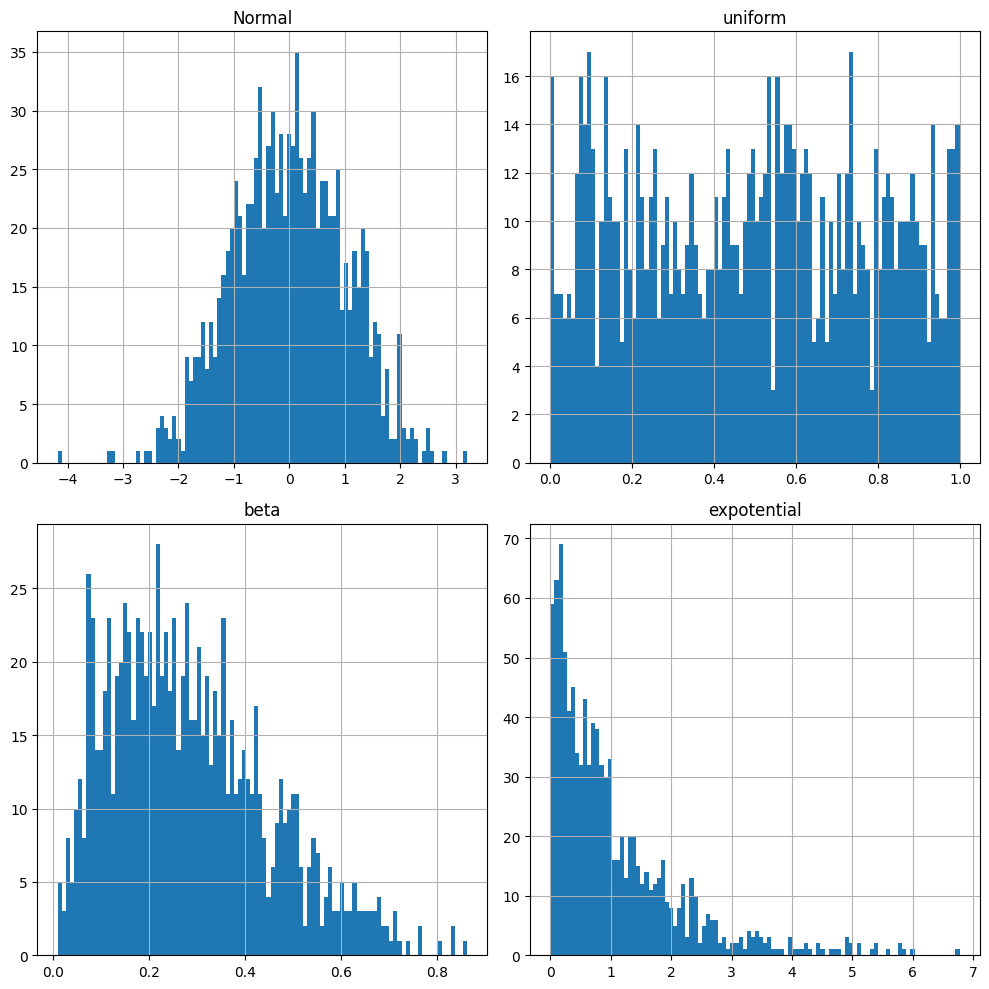

In [172]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Plot each histogram on a separate subplot
data1["A"].hist(bins=100, ax=axes[0, 0])
axes[0, 0].set_title('Normal')

data1["B"].hist(bins=100, ax=axes[0, 1])
axes[0, 1].set_title('uniform')

data1["C"].hist(bins=100, ax=axes[1, 0])
axes[1, 0].set_title('beta')

data1["D"].hist(bins=100, ax=axes[1, 1])
axes[1, 1].set_title('expotential')

# Adjust the layout
plt.tight_layout()
plt.show()

In [190]:
# data_fnlwgt_ct_gan =ct_gan_syntheric_data [' fnlwgt']
# data_fnlwgt_TVAE =TVAE_synthetic_data [' fnlwgt']
data_age_GC =synthetic_data ['age']


# best_fit, p_value = best_fit_distribution(data_fnlwgt_ct_gan)


# print(best_fit,p_value)

In [191]:
# best_fit, p_value = best_fit_distribution(data_fnlwgt_TVAE)


# print(best_fit,p_value)

In [192]:
best_fit, p_value = best_fit_distribution(data_age_GC)


print(best_fit,p_value)

norm 3.1951426192399973e-75


We can see that this p-value is too small, it is not confident enough to say that this distribution is normal distribution

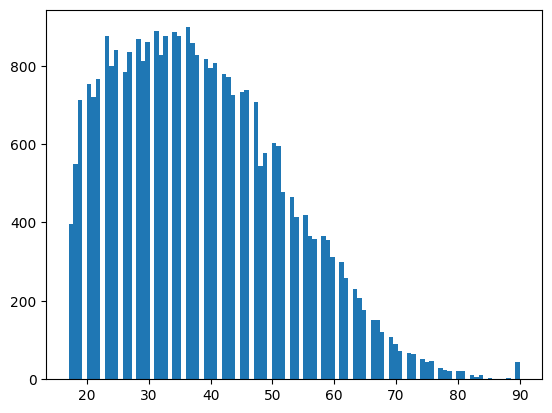

In [193]:
real_age = data['age']
plt.hist(real_age, bins = 100)
plt.show()

In [194]:
best_fit, p_value = best_fit_distribution(real_age)


print(best_fit,p_value)

norm 5.1419665705512075e-113


### Column-wise Evaluation

#### Statistical Metrics Explained

- **Mean**: The average value of the dataset, calculated by summing all values and dividing by the number of values.

- **Median**: The middle value of the dataset when it is ordered from smallest to largest. If there is an even number of observations, it is the average of the two middle values.

- **Standard Deviation**: A measure of how spread out the values in the dataset are around the mean. A smaller standard deviation indicates that the values are closer to the mean, and a larger one indicates a wider spread.

- **Range**: The difference between the largest and smallest values in the dataset, giving an idea of the span of the data.

- **IQR (Interquartile Range)**: The range of the middle 50% of the data. It is calculated by subtracting the 25th percentile (Q1) from the 75th percentile (Q3), providing a measure of the dataset's central spread.

- **Skewness**: Indicates the asymmetry of the distribution of values in the dataset. A skewness close to zero suggests a symmetrical distribution. Positive skewness indicates a distribution with an extended tail on the right side, and negative skewness indicates a distribution with an extended tail on the left side.

- **Kurtosis**: Reflects the "tailedness" of the distribution. High kurtosis indicates a distribution with heavy tails and sharp peaks (more outliers), while low kurtosis indicates a distribution with light tails and less extreme outliers.


In [200]:
data_age = s_data['age']
synthetic_data_age = synthetic_data['age']
def compute_descriptive_stats(data):
    """Compute descriptive statistics for a given dataset."""
    # Convert to a Pandas Series if input is a numpy array
    if isinstance(data, np.ndarray):
        data = pd.Series(data)
    
    stats = {
        'Mean': data.mean(),
        'Median': data.median(),
        'Standard Deviation': data.std(),
        'Range': data.max() - data.min(),
        'IQR': data.quantile(0.75) - data.quantile(0.25),
        'Skewness': data.skew(),
        'Kurtosis': data.kurtosis()
    }
    
    return pd.Series(stats)


original_stats = compute_descriptive_stats(data_age)
synthetic_stats = compute_descriptive_stats(synthetic_data_age)

# Display the stats side-by-side for comparison
comparison_df = pd.DataFrame({'Original Data': original_stats, 'Synthetic Data (Gaussian Copula)': synthetic_stats})

comparison_df


,Original Data,Synthetic Data (Gaussian Copula)
Mean,38.538391,38.451132
Median,37.000000,36.000000
Standard Deviation,13.644113,13.971686
Range,73.000000,73.000000
IQR,20.000000,20.000000
Skewness,0.554539,0.680635
Kurtosis,-0.204705,-0.117864


In [201]:
data_age = s_data['age']
synthetic_data_age = ct_gan_syntheric_data['age']

original_stats = compute_descriptive_stats(data_age)
synthetic_stats = compute_descriptive_stats(synthetic_data_age)

# Display the stats side-by-side for comparison
comparison_df = pd.DataFrame({'Original Data': original_stats, 'Synthetic Data (CT-GAN)': synthetic_stats})

comparison_df

,Original Data,Synthetic Data (CT-GAN)
Mean,38.538391,37.773282
Median,37.000000,38.000000
Standard Deviation,13.644113,13.551463
Range,73.000000,73.000000
IQR,20.000000,20.000000
Skewness,0.554539,0.466456
Kurtosis,-0.204705,-0.292764


In [202]:
data_age = s_data['age']
synthetic_data_age = TVAE_synthetic_data['age']

original_stats = compute_descriptive_stats(data_age)
synthetic_stats = compute_descriptive_stats(synthetic_data_age)

# Display the stats side-by-side for comparison
comparison_df = pd.DataFrame({'Original Data': original_stats, 'Synthetic Data (TVAE)': synthetic_stats})

comparison_df

,Original Data,Synthetic Data (TVAE)
Mean,38.538391,36.684990
Median,37.000000,35.000000
Standard Deviation,13.644113,12.102007
Range,73.000000,63.000000
IQR,20.000000,14.000000
Skewness,0.554539,0.720357
Kurtosis,-0.204705,0.031710


In [203]:
data_age = s_data['age']
synthetic_data_age = data_hold['age']

original_stats = compute_descriptive_stats(data_age)
synthetic_stats = compute_descriptive_stats(synthetic_data_age)

# Display the stats side-by-side for comparison
comparison_df = pd.DataFrame({'Original Data': original_stats, 'Synthetic Data (Data_hold)': synthetic_stats})

comparison_df

,Original Data,Synthetic Data (Data_hold)
Mean,38.538391,38.646526
Median,37.000000,37.000000
Standard Deviation,13.644113,13.635177
Range,73.000000,73.000000
IQR,20.000000,20.000000
Skewness,0.554539,0.565177
Kurtosis,-0.204705,-0.107902


### Obervations:
1. All the P-value is pretty small
2. Might have another distribution method that are not listed in the SDV paper